<a href="https://colab.research.google.com/github/ArmandDS/topic_modeling/blob/master/topic_modeling_spanish.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this article we will implementing topics model with gensim, topic models are 
probabilistic models which contains information about topics in the
text. A topic is like theme, or in other words underlying ideas represented in text. 
For example, we are working with a corpus of **spanish newspaper articles**,
possible topics would be  politics, conflicts, elections and so on.

#### Load the libraries

In [40]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
import string
import matplotlib.pyplot as plt
import gensim
import numpy as np
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
#from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
from gensim.models.wrappers import LdaMallet


ModuleNotFoundError: No module named 'gensim.models.wrappers'

In [108]:
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

### Connect to drive to get the data

In [2]:
import pandas as pd
df_news = pd.read_pickle("udemy_reviews.pkl")
df_news['tag']=df_news['rating'].apply(lambda x: 'pos' if x > 4 else 'neg')
df_news.sample(10)

,id,course,rating,comment,user,tag
31070,75541084,1444542,5.0,el curso va excelente,Crystian Luiyi Garcia Huallpa,pos
50331,80809044,1583448,1.5,"Poco profesional, el impartidor no sabe hablar...",Mauricio Alvarez Rodriguez,neg
18926,88845624,2696806,5.0,Muy buenas y didácticas las explicaciones hast...,Hernan Daniel Briceño,pos
23750,41980642,426982,5.0,Totalmente.,William Edward Rojas Godoy,pos
6104,33530666,1982518,4.0,Fue una buena elección por el lado de las prác...,Yenún Gisel González O,neg
67991,73207054,2191124,5.0,"Es un curso excelente, explicaciones claras y ...",Antonio Balver,pos
72820,51921548,498976,4.0,me gustaria el instalador para win 10,Fernando Yanez,neg
41585,66460458,1714514,5.0,El curso apesar de ser gratis está muy complet...,Paulo Mateos,pos
37410,63493368,3072640,5.0,El curso enseña Entity Framework Core a detall...,Alonso Navarro,pos
9521,58347389,1187434,5.0,"He aprendido mucho y se entiende muy bien, exc...",Danny Gaitan Gomez,pos


In [3]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 174141 entries, 6545 to 80394
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       174141 non-null  int64  
 1   course   174141 non-null  int64  
 2   rating   174141 non-null  float64
 3   comment  174141 non-null  object 
 4   user     174141 non-null  object 
 5   tag      174141 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB


#Data Preprocessing

We defined a list of custom words to be exclude from our dataset

In [4]:
black_list = ['más', 'mas', 'unir', 'paises', 'pais', 'espa', 'no', 'os', 'a', 'compa', 'acompa', 'off', 'and', 'grecia', 'the','it', 'to',
              'd',  'et',  'dame',  'il',  'dans', 'that',  'as',   'for',  'it',  'elections',  'would',  'this',  'with', 'york', 'obama', 'chavez', 'gadafi']

Create the cleaner function to clean the spanish text, remove non alpha numeric characters, remove duplicate, remove spanish accutes, remove digits

In [5]:
def cleaner(word):
    word = re.sub(r'((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*', '', word, flags=re.MULTILINE)
    word = re.sub(r'(?::|;|=)(?:-)?(?:\)|\(|D|P)', "", word)
    word = re.sub(r'ee.uu', 'eeuu', word)
    word = re.sub(r'\#\.', '', word)
    word = re.sub(r'\n', '', word)
    word = re.sub(r',', '', word)
    word = re.sub(r'\-', ' ', word)
    word = re.sub(r'\.{3}', ' ', word)
    word = re.sub(r'a{2,}', 'a', word)
    word = re.sub(r'é{2,}', 'é', word)
    word = re.sub(r'i{2,}', 'i', word)
    word = re.sub(r'ja{2,}', 'ja', word) 
    word = re.sub(r'á', 'a', word)
    word = re.sub(r'é', 'e', word)
    word = re.sub(r'í', 'i', word)
    word = re.sub(r'ó', 'o', word)
    word = re.sub(r'ú', 'u', word)  
    word = re.sub('[^a-zA-Z]', ' ', word)
    list_word_clean = []
    for w1 in word.split(" "):
        if  w1.lower() not in stopwords:
            list_word_clean.append(w1.lower())

    bigram_list = bigram[list_word_clean]
    out_text = lemmatization(" ".join(bigram_list))
    return out_text

Create the function for select **only nouns** for our data, this way we are removing adverb, adjetives, verbs, etc. This is doing with spacy

In [6]:
def lemmatization(texts, allowed_postags=['NOUN']):
    texts_out = [ token.text for token in nlp(texts) if token.pos_ in 
                 allowed_postags and token.text not in black_list and len(token.text)>2]
    return texts_out

For gensim we need a list of text, so we need do convert the dataframe to list

In [10]:
len(df_news['comment'].to_list())

174141

Then we look for bigram in our data, i.e pair of words that together have more meanful for our model

In [13]:
%%time
bigram = gensim.models.Phrases(df_news['comment'].to_list()) 

Wall time: 18.8 s


Let's examine some output

In [14]:
bigram[df_news['comment'].to_list()[20000].split()]

['Excelente',
 'curso,',
 'muy',
 'conciso,',
 'videos',
 'cortos',
 'y',
 'llevaderos.']

In [15]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Faolin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Faolin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [16]:
from nltk import word_tokenize
from nltk.corpus import stopwords
stop = set(stopwords.words('spanish'))

additional_stopwords=set(black_list)

stopwords = stop.union(additional_stopwords)

We are using Spacy For lemmatize spanish words

In [18]:
!python -m spacy download es_core_news_md

  Using cached https://github.com/explosion/spacy-models/releases/download/es_core_news_md-3.1.0/es_core_news_md-3.1.0-py3-none-any.whl (42.7 MB)
[+] Download and installation successful
You can now load the package via spacy.load('es_core_news_md')


In [25]:
import spacy
nlp = spacy.load('es_core_news_md')

Now let's test the cleaner function:

In [26]:
df_news['comment'][100]

'FUE UNA BUENA ELECCION, BRINDA HERRAMIENTAS APLICABLES'

In [27]:
cleaner(df_news['comment'][100])


['eleccion', 'herramientas']

The Cleaner function work properly

##### Let's clean all the text

In [29]:
df_news['text2'] = df_news['comment']

In [31]:
from tqdm.notebook import tqdm
tqdm.pandas()

df_news['comment_cleaned'] = df_news['comment'].progress_apply(cleaner)

  0%|          | 0/174141 [00:00<?, ?it/s]

Now we need to build the *corpus* and the *dictionary* that gensim need to work, to do that we need to pass a list of list of tokens

In [33]:
df_news['comment_cleaned'] = df_news['comment']
df_news['comment_cleaned'][:10]

6545                                         [rpa, fotos]
6546                                      [conocimientos]
6547                                                   []
6548                                                   []
6733                                                   []
6734                                            [mayoria]
6735                                              [circo]
6736                                          [contenido]
6737    [curso, curso, placer, capitulo, curso, placer...
6738                  [calidad, cursos, archivos, sonido]
Name: comment_cleaned, dtype: object

In [41]:
dictionary = Dictionary(df_news['comment_cleaned'].to_list())
dictionary.compactify()
# Filter extremes
dictionary.filter_extremes(no_below=2, no_above=0.97, keep_n=None)
dictionary.compactify()

corpus = [dictionary.doc2bow(text) for text in df_news['comment_cleaned'].to_list()]

# Now let's do the modeling part

We are comparing 3 topic modeling algorithm Latent Dirichlet Allocation (LDA), Latent
semantic analysis (LSA), Hierarchical Dirichlet Process
(HDP),in order to evaluate topic models we will be using **topic coherence**, which is a measure of how
interpretable topics are for human beings.

 ## Hierarchical Dirichlet process Model

In [44]:
hdpmodel = HdpModel(corpus=corpus, id2word=dictionary, random_state= 30)

and the topics of this model:

In [46]:
def display_topics(model, model_type="lda"):
    for topic_idx, topic in enumerate(model.print_topics()):
        print ("Topic %d:" % (topic_idx))
        if model_type== "hdp":
            print (" ".join(re.findall( r'\*(.[^\*-S]+).?', topic[1])), "\n")
        else:
            print (" ".join(re.findall( r'\"(.[^"]+).?', topic[1])), "\n")


In [47]:
# hdpmodel.show_topics() 

display_topics(hdpmodel, model_type="hdp")

Topic 0:
curso  gracias  cosas  tema  instructor  temas  conceptos  contenido  ejemplos  manera 

Topic 1:
curso  gracias  eleccion  cursos  ejemplos  conceptos  momento  tema  profesor  cosas 

Topic 2:
curso  gracias  eleccion  cosas  explicacion  ejemplos  contenido  momento  instructor  temas 

Topic 3:
curso  eleccion  gracias  explicacion  momento  conceptos  tema  cosas  contenido  temas 

Topic 4:
curso  gracias  eleccion  explicacion  contenido  momento  conceptos  cosas  explicaciones  ejemplos 

Topic 5:
curso  gracias  eleccion  momento  explicacion  contenido  instructor  cosas  conceptos  tema 

Topic 6:
curso  gracias  eleccion  cosas  explicacion  momento  contenido  tema  conceptos  cursos 

Topic 7:
curso  gracias  eleccion  cosas  momento  explicacion  temas  tema  conceptos  instructor 

Topic 8:
curso  gracias  eleccion  explicacion  cosas  conceptos  momento  temas  contenido  tema 

Topic 9:
curso  gracias  eleccion  momento  cosas  explicacion  explicaciones  co

as we could see there are 20 topics, however is kind of dificult to interpret or follow, so we decide to move to another model.





In [51]:
def evaluate_graph(dictionary, corpus, texts, limit, model):
    """
    Function to display num_topics - LDA graph using c_v coherence
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    
    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    c_v = []
    lm_list = []
    for num_topics in range(1, limit):
        if model == 'lsi':
            lm = LsiModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        else:
            lm = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        lm_list.append(lm)
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())
        
    # Show graph
    x = range(1, limit)
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()
    
    return lm_list, c_v

##LSI MODEL

In [ ]:
lsimodel = LsiModel(corpus=corpus, num_topics=10, id2word=dictionary)

In [50]:
display_topics(lsimodel)  # Showing the topics

NameError: name 'lsimodel' is not defined

It seen that with 10 topics there is some themes with keywords related to: trump, venezuela, police, electiones, terrorism; still is a little difficult to gt some insight, because of this we are trying to select the best number of topics by iterate over a range of values and looking the coherence 

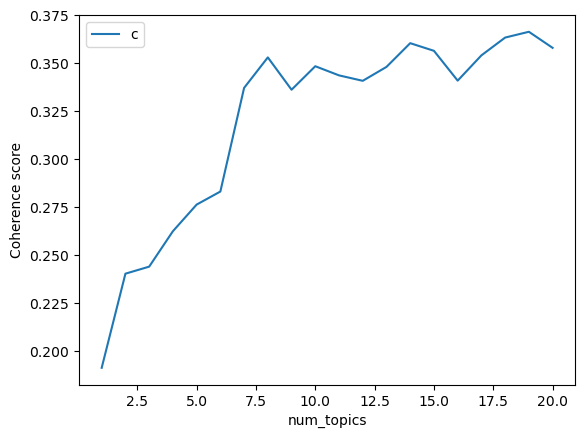

Wall time: 8min 40s


In [52]:
%%time
lmlist_lsi, c_v = evaluate_graph(dictionary=dictionary, corpus=corpus, texts=df_news['comment_cleaned'].to_list(), limit=21, model= "lsi")

According to the coherence the best number of topics are between 3-7, however you must select the topics using both the coherence and visual inspection.


In [56]:
display_topics(lmlist_lsi[2])

Topic 0:
presidente gobierno personas ministro seguridad atentados parte venezuela trump policia 

Topic 1:
presidente atentados venezuela trump policia personas gobierno juan paris ataques 

Topic 2:
trump venezuela gobierno juan nicolas casa clinton votos noviembre elecciones 



Now, Let's try another model

## Latent Dirichlet Allocation Model

In [53]:
ldamodel = LdaModel(corpus=corpus, num_topics=10, id2word=dictionary)

In [54]:
display_topics(ldamodel)

Topic 0:
explicacion cursos programa persona claridad formacion practicas publicidad ritmo ambiente 

Topic 1:
curso dudas idea personas basura confianza verdad funciones sistema estrellas 

Topic 2:
curso conocimiento mundo profesor desarrollo detalle web pena felicitaciones preguntas 

Topic 3:
eleccion contenido experiencia bases calidad ideas proyectos grano conciencia guia 

Topic 4:
gracias curso manera programacion vida ejercicios expectativas nivel lenguaje negocio 

Topic 5:
conceptos temas instructor ejemplos ayuda tema clases dise teoria leccion 

Topic 6:
gusto momento paso tiempo herramientas verdad clase ademas puntos juego 

Topic 7:
tema curso forma videos super proyecto uso aprendizaje base pasos 

Topic 8:
explicaciones introduccion consejos encanto material vez ejemplo practica audio inicio 

Topic 9:
cosas informacion conocimientos parte video tips falta punto veces html 



Find out the optimal number of topics for the LDA model based on the coherence metric:

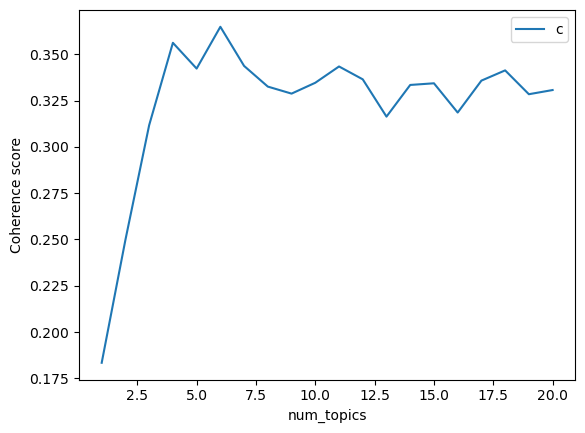

Wall time: 10min 22s


In [55]:
%%time
lmlist, c_v = evaluate_graph(dictionary=dictionary, corpus=corpus, texts=df_news['comment_cleaned'].to_list(), limit=21, model= "lda")

For this model it seems that  9 or 18, again we must to check the keywords too.

### Comparing the Model Coherence of the Best Models

we made 3 models, now let's compare each other's  coherence

In [56]:
ldamodel = lmlist[11]
lsimodel = lmlist_lsi[2]

lsitopics = [[word for word, prob in topic] for topicid, topic in lsimodel.show_topics(formatted=False)]

hdptopics = [[word for word, prob in topic] for topicid, topic in hdpmodel.show_topics(formatted=False)]

ldatopics = [[word for word, prob in topic] for topicid, topic in ldamodel.show_topics(formatted=False)]

In [57]:
lsi_coherence = CoherenceModel(topics=lsitopics[:10], texts=df_news['comment_cleaned'].to_list(), dictionary=dictionary, window_size=10).get_coherence()

hdp_coherence = CoherenceModel(topics=hdptopics[:10], texts=df_news['comment_cleaned'].to_list(), dictionary=dictionary, window_size=10).get_coherence()

lda_coherence = CoherenceModel(topics=ldatopics, texts=df_news['comment_cleaned'].to_list(), dictionary=dictionary, window_size=10).get_coherence()

In [58]:
import seaborn as sns

coherences = [lsi_coherence, hdp_coherence, lda_coherence]
n = len(coherences)
x = ['lsi_coherence','hdp_coherence', 'lda_coherence']
sns.barplot(x, coherences)


C:\Users\Faolin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

We can see that the **LdaModel** model **with 8 topics** has the higher value of
coherence

Examine the keyword to get the topics of the best model

In [59]:

display_topics(ldamodel)

Topic 0:
gracias curso forma verdad vida nivel tips negocio ideas felicitaciones 

Topic 1:
cosas curso mundo introduccion encanto expectativas clase herramienta audio practicas 

Topic 2:
manera experiencia cursos calidad punto vez problema plataforma grano publicidad 

Topic 3:
conceptos contenido informacion desarrollo preguntas maestro funciones vision aspectos concepto 

Topic 4:
conocimientos instructor programacion consejos herramientas clases bases base datos detalles 

Topic 5:
explicacion tema conocimiento parte aprendizaje material hora instructor tipo objetivo 

Topic 6:
momento videos paso super dudas dise juego partes metodologia opcion 

Topic 7:
curso ejemplo lenguaje cuenta pagina inicio gente formacion errores aporte 

Topic 8:
ejemplos idea video ademas ejercicios uso falta pasos detalle veces 

Topic 9:
curso personas pena empresa tiempo html titulo embargo sector comienzo 

Topic 10:
gusto temas ayuda proyecto programa tiempo puntos practica persona trabajo 

Topic

It looks like the topics are:
* Topic 0: felicitaciones
* Topic 1: expectativas
* Topic 2: experiencia
* Topic 3: contenido
* Topic 4: instructor
* Topic 5: material
* Topic 6: video
* Topic 7: lenguaje
* Topic 8: ejercicios
* Topic 9: titulo
* Topic 10: temas
* Topic 11: explicación


In [73]:
label_dicc = {0:'felicitaciones', 1:'expectativas', 2:'experiencia', 3: 'contenido', 4:'instructor', 5:'material', 6:'video', 
              7:'lenguaje', 8:'ejercicios', 9: 'titulo', 10:'temas', 11:'explicación'}

Let´s check the keyword when we selecting another number of topics (14)

In [60]:
ldamodel_16 =lmlist[16]


In [61]:
display_topics(ldamodel_16)

Topic 0:
experiencia aprendizaje material pasos ganas inicio gente proyectos empresa ambiente 

Topic 1:
tema informacion videos video calidad claridad aspectos vision dominio concreto 

Topic 2:
eleccion explicacion gusto paso audio pesar calificacion modulo espectativas dinero 

Topic 3:
tiempo ayuda ademas vida curso puntos detalle hora felicitaciones voz 

Topic 4:
ejemplo proyecto expectativas falta curso herramienta veces problema publicidad estructura 

Topic 5:
forma conocimiento instructor cursos curso desarrollo negocio partes proceso utilidad 

Topic 6:
ejemplos clases tambien confianza errores teoria sistema estrellas nociones curso 

Topic 7:
profesor super dudas uso lenguaje curso trabajo recursos manejo formacion 

Topic 8:
manera programacion parte curso bases tips embargo punto cuenta pagina 

Topic 9:
base datos caso metodologia terminos contenidos fin principio lecciones etiquetas 

Topic 10:
cosas momento conocimientos programa persona objetivo tutor realidad resume

# Classifiying all documents

now that we have been select the best model and topics number, is time to assign a topic to each document, means **cluster** according to the topics

In [64]:
from tqdm.notebook import tqdm_notebook

def format_topics_sentences(ldamodel=0, corpus=corpus, texts=0):
    # Init output
    sent_topics_df = pd.DataFrame()-n

    # Get main topic in each document
    for i, row in tqdm_notebook(enumerate(ldamodel[corpus]), total=len(ldamodel[corpus])):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel, corpus=corpus, texts=df_news['comment_cleaned'].to_list())



  0%|          | 0/174141 [00:00<?, ?it/s]

In [76]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.5418,"manera, experiencia, cursos, calidad, punto, v...","[rpa, fotos]"
1,1,4.0,0.5417,"conocimientos, instructor, programacion, conse...",[conocimientos]
2,2,0.0,0.0833,"gracias, curso, forma, verdad, vida, nivel, ti...",[]
3,3,0.0,0.0833,"gracias, curso, forma, verdad, vida, nivel, ti...",[]
4,4,0.0,0.0833,"gracias, curso, forma, verdad, vida, nivel, ti...",[]
5,5,9.0,0.5416,"curso, personas, pena, empresa, tiempo, html, ...",[mayoria]
6,6,7.0,0.0833,"curso, ejemplo, lenguaje, cuenta, pagina, inic...",[circo]
7,7,3.0,0.5417,"conceptos, contenido, informacion, desarrollo,...",[contenido]
8,8,9.0,0.5099,"curso, personas, pena, empresa, tiempo, html, ...","[curso, curso, placer, capitulo, curso, placer..."
9,9,2.0,0.8167,"manera, experiencia, cursos, calidad, punto, v...","[calidad, cursos, archivos, sonido]"


We selected the ldamodel with 12 topics and asigned a dominant topic to each document, now let map each topic with a label 

first let's create the dictionary

In [77]:
label_dicc = {0:'felicitaciones', 1:'expectativas', 2:'experiencia', 3: 'contenido', 4:'instructor', 5:'material', 6:'video', 
              7:'lenguaje', 8:'ejercicios', 9: 'titulo', 10:'temas', 11:'explicación'}

In [78]:
df_dominant_topic['Dominant_Topic'] = df_dominant_topic['Dominant_Topic'].astype('int64')


In [118]:
df_dominant_topic['Dominant_Topic'] = df_dominant_topic['Dominant_Topic'].map(label_dicc)
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,NaN,0.5418,"manera, experiencia, cursos, calidad, punto, vez, problema, plataforma, grano, publicidad","[rpa, fotos]"
1,1,NaN,0.5417,"conocimientos, instructor, programacion, consejos, herramientas, clases, bases, base, datos, detalles",[conocimientos]
2,2,NaN,0.0833,"gracias, curso, forma, verdad, vida, nivel, tips, negocio, ideas, felicitaciones",[]
3,3,NaN,0.0833,"gracias, curso, forma, verdad, vida, nivel, tips, negocio, ideas, felicitaciones",[]
4,4,NaN,0.0833,"gracias, curso, forma, verdad, vida, nivel, tips, negocio, ideas, felicitaciones",[]
5,5,NaN,0.5416,"curso, personas, pena, empresa, tiempo, html, titulo, embargo, sector, comienzo",[mayoria]
6,6,NaN,0.0833,"curso, ejemplo, lenguaje, cuenta, pagina, inicio, gente, formacion, errores, aporte",[circo]
7,7,NaN,0.5417,"conceptos, contenido, informacion, desarrollo, preguntas, maestro, funciones, vision, aspectos, concepto",[contenido]
8,8,NaN,0.5099,"curso, personas, pena, empresa, tiempo, html, titulo, embargo, sector, comienzo","[curso, curso, placer, capitulo, curso, placer, amor, namaste]"
9,9,NaN,0.8167,"manera, experiencia, cursos, calidad, punto, vez, problema, plataforma, grano, publicidad","[calidad, cursos, archivos, sonido]"


In [99]:
df_news['labels'] = df_dominant_topic['Dominant_Topic']
df_news['label_confidence'] = df_dominant_topic['Topic_Perc_Contrib']

Let's examine some text and its topics

In [117]:
df_news[['comment', 'labels']].head(10)

,comment,labels
6545,"[rpa, fotos]",instructor
6546,[conocimientos],contenido
6547,[],expectativas
6548,[],titulo
6733,[],felicitaciones
6734,[mayoria],felicitaciones
6735,[circo],video
6736,[contenido],felicitaciones
6737,"[curso, curso, placer, capitulo, curso, placer, amor, namaste]",explicación
6738,"[calidad, cursos, archivos, sonido]",felicitaciones


In [115]:
df_news[ df_news['labels'] == 'instructor'].sort_values(by='label_confidence',ascending=False).head(10)

,id,course,rating,comment,user,tag,text2,comment_cleaned,labels,label_confidence
1892,75710650,1066626,4.5,[conceptos],Manuela Naranjo,pos,Bastante explicativo. Y conceptos bastante amplios y precisos,[conceptos],instructor,0.8407
1892,74399306,3729250,5.0,[curso],Christian Perfido,pos,"ES AVANZADO Y EXPLICA MUY BIEN FELICITACIONES,POR TAN BUEN CURSO",[curso],instructor,0.8407
4318,76655150,1437440,5.0,[curso],Ricardo Blanco,pos,"Excelente, curso muy bien explicado",[curso],instructor,0.8166
4318,4726536,888952,5.0,[tema],Nataliadelavictoriamarin,pos,explica muy bien cada tema,[tema],instructor,0.8166
4318,67920702,1254192,5.0,"[nivel, paso, curso, favor, concreto, tiempo]",Julio Mejia,pos,Se requiere ya un nivel intermedio para seguirle el paso al curso pero en su favor es muy concreto con lo que muestra y se aprende mucho en muy poco tiempo,"[nivel, paso, curso, favor, concreto, tiempo]",instructor,0.8166
2682,77037506,1698124,3.0,"[ejemplos, gente]",Otmar Escutia,neg,"Creo que podría ser mejor con ejemplos vivenciales (videos de gente exponiendo) o bien acompañar con imágenes, hasta ahorita interesante pero un tanto aburrido.","[ejemplos, gente]",instructor,0.7709
17771,81112862,1910458,5.0,[],Gabriel Splendiani,pos,Me pareció muy bueno y abarca muchísimo. Yo vengo de Unity y sinceramente lo entendí todo a la perfección.,[],instructor,0.7708
5317,69249998,2691362,5.0,[gusto],Mauricio Antriz,pos,me gusto,[gusto],instructor,0.7708
66011,54136276,948830,2.5,"[autor, muletillas]",Daniel Medrano,neg,El autor utiliza muchas muletillas al hablar y eso dificulta entender lo que dice.,"[autor, muletillas]",instructor,0.7708
5317,24470942,1175904,4.5,"[curso, grano, explicaciones, xamarinforms]",Raúl Carreño,pos,"Muy buen curso!, va directo al grano con las explicaciones.\nMe sirvió para empezar a incursionar en XamarinForms.\n\nSaludos.","[curso, grano, explicaciones, xamarinforms]",instructor,0.7708


In [119]:
df_news.sort_values(by='label_confidence',ascending=False).head(10)

,id,course,rating,comment,user,tag,text2,comment_cleaned,labels,label_confidence
64288,66692936,2066697,5.0,"[explicacion, tema, volumen]",Victor Alonso Castillo,pos,"Todo muy bien, siento que la explicacion es un poco lenta y repetitiva pero se da muy bien a entender cada tema, algo que creo que si se le deberia de mejorar es el volumen del microfono, se escucha un poco bajo","[explicacion, tema, volumen]",experiencia,0.8690
64288,57768281,1913070,5.0,"[tema, tiempo]",Zuriel Antonio Franco Lara,pos,Se entiende perfectamente cada tema explicado y en poco tiempo,"[tema, tiempo]",experiencia,0.8690
68799,68138781,1816438,5.0,[paso],Juan de Dios Sanchez Mariscal,pos,"Se entiende perfectamente,todo lo que se dice paso por paso.",[paso],felicitaciones,0.8472
2325,93063142,3264424,5.0,"[curso, metodologia, anza]",Rene Bustamante,pos,"Excelente curso, buena metodología de enseñanza... totalmente recomendado.","[curso, metodologia, anza]",felicitaciones,0.8472
9908,22768516,729456,4.0,"[curso, experiencia, explicativo]",Cristian Farid Casih,neg,"El curso estuvo bueno era lo que esperaba tener una primera experiencia en django, fue poco explicativo pero es entendible","[curso, experiencia, explicativo]",titulo,0.8472
9908,34516504,290864,4.0,[],pallob sarker,neg,It's good for beginner.,[],titulo,0.8472
55673,17612326,1327314,4.5,"[curso, uso, consejos, conversiones, finalidad, campa, curso]",Andrea Ramírez,pos,"Si bien el curso esta enfocado principalmente en el uso de mailchimp, se agradecería que pudiese incorporar más consejos para generar conversiones, pensando que esa es la finalidad de las campañas de email masivos. En general, excelente curso.","[curso, uso, consejos, conversiones, finalidad, campa, curso]",felicitaciones,0.8472
9908,62778440,3085400,5.0,[curso],César Israel León Cifuentes,pos,Me está encantado el curso!,[curso],titulo,0.8472
9908,72023844,775264,5.0,[],Ricardo Terán Navarro,pos,Excelente,[],titulo,0.8472
68799,72207158,115204,4.0,[],Anonymized User,neg,Entendible y didáctico,[],felicitaciones,0.8472


### let's see the distribution of topics


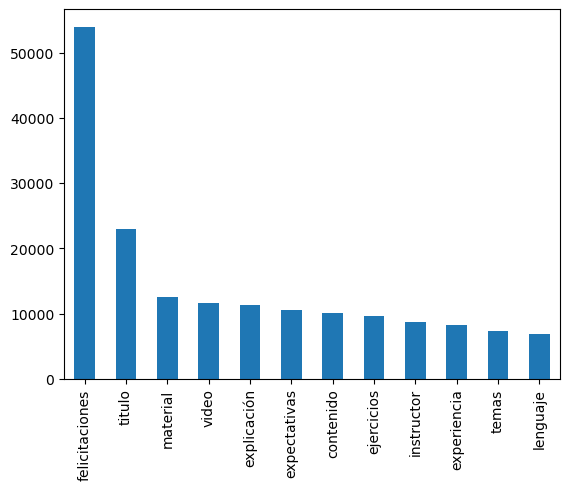

In [83]:
ax = df_dominant_topic['Dominant_Topic'].value_counts().plot(kind='bar')
plt.show()

The topis are almost balanced, so we are good

finally that we have our models set up, as well as analyzed, we can go
ahead to visualizing them.

In [84]:
!pip install pyLDAvis

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\Faolin\\anaconda3\\Lib\\site-packages\\~umpy\\core\\_multiarray_tests.cp38-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136897 sha256=6affa75844afd880e076d6586d6f8bbcec52503961c4cb8ca86fbdedfae3f11d
  Stored in directory: c:\users\faolin\appdata\local\pip\cache\wheels\90\61\ec\9dbe9efc3acf9c4e37ba70fbbcc3f3a0ebd121060aa593181a
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1317 sha256=10a66a2f8960f8c4131c9878086eb447a7b0ab29f1dee6dbb428f5f3d557d412
  Stored in directory: c:\users\faolin\appdata\local\pip\cache\wheels\22\0b\40\fd3f795caaa1fb4c6cb738bc1f56100be1e57da95849bfc897
Successfully built pyLDAvis sklearn
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.2
    Uninstalling numpy-1.19.2:
      Successfully uninstalled numpy-1.19.2


In [86]:
import pyLDAvis

pyLDAvis.enable_notebook()

ModuleNotFoundError: No module named 'pyLDAvis'

In [87]:
# %%time
import pyLDAvis.gensim
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

ModuleNotFoundError: No module named 'pyLDAvis'